<a href="https://colab.research.google.com/github/PamudithaSomarathne/EN2550/blob/master/4%20Neural%20Network/EN2550_Assignment_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and prepare the dataset

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Download and categorize data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
K = len(np.unique(y_train))

# Compute data parameters
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = x_train[0].size

# Normalize pixel values
x_train, x_test = x_train/255.0, x_test/255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert labels from integers to binary
y_train = keras.utils.to_categorical(y_train, num_classes=K).astype(np.float64)
y_test = keras.utils.to_categorical(y_test, num_classes=K).astype(np.float64)

# Reshape data and convert to float32
x_train = x_train.reshape((Ntr,Din)).astype(np.float64)
x_test = x_test.reshape((Nte,Din)).astype(np.float64)

# Generate train validation splits
train_val_split = 0.9
use_val = False if train_val_split==1.0 else True
if use_val:
  x_train, x_val = x_train[:int(Ntr*train_val_split)], x_train[int(Ntr*train_val_split):]
  y_train, y_val = y_train[:int(Ntr*train_val_split)], y_train[int(Ntr*train_val_split):]
  Ntr,Nv = x_train.shape[0],x_val.shape[0]

class_labels = ["airplane", "automobile", "bird", "cat", "deer", 
                "dog", "frog", "horse", "ship", "truck"]

print("Training data size :", x_train.shape, "\nTraining label size :",\
      y_train.shape)
if use_val: print("Validation data size:", x_val.shape,\
      "\nValidation label size:", y_val.shape)
print("Test data size :", x_test.shape, "\nTest label size :", y_test.shape)
print("No of classes :", K)

Training data size : (45000, 3072) 
Training label size : (45000, 10)
Validation data size: (5000, 3072) 
Validation label size: (5000, 10)
Test data size : (10000, 3072) 
Test label size : (10000, 10)
No of classes : 10


# Part 1: Linear classifier

In [3]:
def initialize_linear_weights(shape, epsilon=0.00001):
  W = np.random.randn(shape[0], shape[1])*epsilon
  b = np.zeros((1,shape[1]))
  return [W,b]

def forward_prop_linear(x_data, weights):
  return np.matmul(x_data, weights[0]) +\
    np.matmul(np.ones((x_data.shape[0],1)),weights[1])

def mean_sum_of_squared_errors_linear(y, y_hat, weights, reg=0.0):
  """ Loss function """
  diff = (y_hat-y).astype(np.float32)
  return np.mean(np.sum(np.multiply(diff,diff),axis=1)) + reg*np.sum(np.multiply(weights[0],weights[0]))

def back_prop_linear(y_hat, y, x):
  return [np.matmul(x.T,2*(y_hat-y))/x.shape[0],np.sum(2*(y_hat-y),axis=0)/x.shape[0]]

def gradient_descent_linear(grads, weights, learning_rate=0.01, reg=0.0):
  weights[0] = weights[0]-learning_rate*grads[0]-reg*weights[0]
  weights[1] = weights[1]-learning_rate*grads[1]
  return weights

def get_accuracy(y_hat, y):
  """ Classification accuracy(top one accuracy) """
  y_hat_bin = np.argmax(y_hat,axis=1)
  y_class = np.argmax(y,axis=1)
  return 100*np.sum(y_hat_bin==y_class)/y_class.size

In [ ]:
no_epochs = 300
weights_linear = initialize_linear_weights((x_train.shape[1],K))
print("Weight sizes\nW:", weights_linear[0].shape,"\nb:",weights_linear[1].shape)

linear_loss_history = []
linear_train_acc_history = []
linear_val_acc_history = []
learning_rate_linear = 0.017
learning_rate_decay_linear = 0.999
regularization_linear = 1e-6

tik = time.time()

seed = 0
rng = np.random.default_rng(seed=seed)

print("\nStarting training of linear model for", no_epochs, "epochs")
for epo in range(no_epochs+1):
  # Shuffle training data
  ind = np.arange(Ntr)
  rng.shuffle(ind)
  x_train_shuffled = x_train[ind]
  y_train_shuffled = y_train[ind]

  # Learing step
  y_hat = forward_prop_linear(x_train_shuffled,weights_linear)
  loss = mean_sum_of_squared_errors_linear(y_train_shuffled, y_hat,\
                                           weights_linear, regularization_linear)
  grads = back_prop_linear(y_hat, y_train_shuffled, x_train_shuffled)
  weights = gradient_descent_linear(grads, weights_linear, learning_rate_linear\
                                    , regularization_linear)

  learning_rate_linear *= learning_rate_decay_linear

  # Maintain history of progression
  train_acc = get_accuracy(y_hat, y_train_shuffled)
  linear_loss_history.append(loss)
  linear_train_acc_history.append(train_acc)
  # Validation
  if use_val:
    y_hat_val = forward_prop_linear(x_val, weights_linear)
    val_acc = get_accuracy(y_hat_val, y_val)
    linear_val_acc_history.append(val_acc)

  if not(epo%20):
    print("Epoch no", epo, "\t| Training loss:",loss, "\t| Training accuracy:",
          np.round(train_acc,2),end=" ")
    if use_val: print("\t| Validation accuracy:", np.round(val_acc,2),end="")
    print()

tok = time.time()
etime = tok-tik
print("Training complete.",int(etime//60),"minutes and", int(etime%60),
      "seconds elapsed.")

Weight sizes
W: (3072, 10) 
b: (1, 10)

Starting training of linear model for 300 epochs
Epoch no 0 	| Training loss: 1.0000228881866686 	| Training accuracy: 9.48 	| Validation accuracy: 24.68
Epoch no 20 	| Training loss: 0.8326676645388843 	| Training accuracy: 37.89 	| Validation accuracy: 37.66
Epoch no 40 	| Training loss: 0.8056839980698832 	| Training accuracy: 39.41 	| Validation accuracy: 38.86
Epoch no 60 	| Training loss: 0.7965554379072088 	| Training accuracy: 40.15 	| Validation accuracy: 39.16
Epoch no 80 	| Training loss: 0.7923654197982295 	| Training accuracy: 40.57 	| Validation accuracy: 39.96
Epoch no 100 	| Training loss: 0.7898361058280808 	| Training accuracy: 40.93 	| Validation accuracy: 40.46
Epoch no 120 	| Training loss: 0.7880207359326384 	| Training accuracy: 41.18 	| Validation accuracy: 40.54
Epoch no 140 	| Training loss: 0.7865955377153278 	| Training accuracy: 41.39 	| Validation accuracy: 40.66
Epoch no 160 	| Training loss: 0.7854235397133447 	| T

Stats for linear classifier
Learning rate: 0.012579427527107027
Training set final mean loss: 0.7805556774059179
Test set mean loss: 188.41037
Test set accuracy: 40.62 %



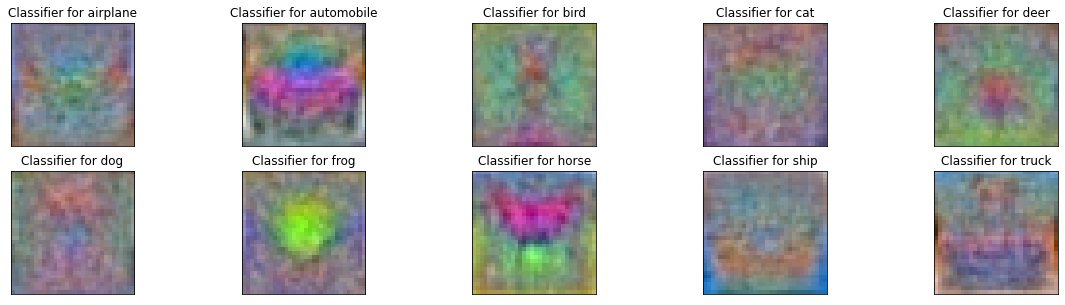

In [ ]:
y_hat_test = forward_prop_linear(x_test,weights_linear)
print("Stats for linear classifier")
print("Learning rate:", learning_rate_linear)
print("Training set final mean loss:", linear_loss_history[-1])
print("Test set mean loss:",mean_sum_of_squared_errors(y_test, y_hat_test))
print("Test set accuracy:", get_accuracy(y_hat_test, y_test),"%\n")

norm_W_linear = (weights_linear[0]-weights_linear[0].min())
norm_W_linear = (255.0*norm_W_linear/norm_W_linear.max()).astype(np.uint8)

fig,ax = plt.subplots(2,5, figsize=(20,5), sharex=True, sharey=True)
for i in range(10):
  weight_image = norm_W_linear[:,i]
  ax[i//5,i%5].set_title("Classifier for " + class_labels[i])
  ax[i//5,i%5].imshow(weight_image.reshape((32,32,3)))
  ax[i//5,i%5].set_xticks([]),ax[i//5,i%5].set_yticks([])
#plt.savefig("images/linear_masks.png")
plt.show()

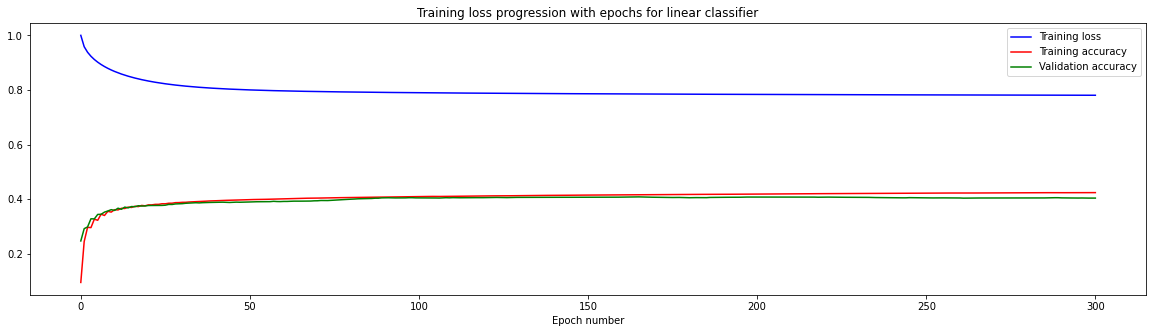

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Training loss progression with epochs for linear classifier")
plt.xlabel("Epoch number")
plt.plot(np.array(linear_loss_history)/max(linear_loss_history), 'b', label="Training loss")
plt.plot(np.array(linear_train_acc_history)/100, 'r', label="Training accuracy")
if use_val: plt.plot(np.array(linear_val_acc_history)/100, 'g', label="Validation accuracy")
plt.legend()
#plt.savefig("images/linear_training_loss.png")
plt.show()

# Part 2: 2-layer neural network

In [4]:
# Activation function
def sigmoid(z):
  return 1/(1+np.exp(-z))

def initialize_2_layer_nn(shape, epsilon=0.001):
  W1 = np.random.randn(shape[0], shape[1])*epsilon
  b1 = np.zeros((1,shape[1]))
  W2 = np.random.randn(shape[1], shape[2])*epsilon
  b2 = np.zeros((1,shape[2]))
  return [W1.astype(np.float64),b1.astype(np.float64),W2.astype(np.float64),
          b2.astype(np.float64)]

def mean_sum_of_squared_errors_2_layer_nn(y, y_hat, weights, reg=0.0):
  """ Loss function """
  diff = (y-y_hat).astype(np.float32)
  return np.mean(np.sum(np.multiply(diff,diff),axis=1)) +\
          reg*np.sum(np.multiply(weights[0],weights[0])) +\
          reg*np.sum(np.multiply(weights[2],weights[2]))

def forward_prop_2_layer_nn(x_data, weights):
  z1 = np.matmul(x_data, weights[0]) + weights[1]
  a1 = sigmoid(z1)
  z2 = np.matmul(a1, weights[2]) + weights[3]
  return [z1,a1,z2]

def back_prop_2_layer_nn(y, xs, weights):
  dz2 = 2*(xs[3]-y)/y.shape[0]
  db2 = np.sum(dz2,axis=0,keepdims=True)
  dW2 = np.matmul(xs[2].T,dz2)
  da1 = np.matmul(dz2,weights[2].T)
  dz1 = xs[2]*(1-xs[2])*da1
  db1 = np.sum(dz1,axis=0,keepdims=True)
  dW1 = np.matmul(xs[0].T, dz1)
  return [dW1,db1,dW2,db2]

def gradient_descent_2_layer_nn(grads, weights, learning_rate=0.01, reg=0.0):
  weights[0] = weights[0]-learning_rate*grads[0]-learning_rate*reg*weights[0]
  weights[1] = weights[1]-learning_rate*grads[1]
  weights[2] = weights[2]-learning_rate*grads[2]-learning_rate*reg*weights[2]
  weights[3] = weights[3]-learning_rate*grads[3]
  return weights

In [54]:
no_epochs = 300
H = 200
weights_nn = initialize_2_layer_nn((x_train.shape[1],H,K))
print("Weight sizes")
for weight in weights_nn:
  print(weight.shape)

nn1_loss_history = []
nn1_train_acc_history = []
nn1_val_acc_history = []
learning_rate_nn1 = 0.015
learning_rate_decay_nn1 = 0.9999
regularization_nn1 = 1e-6

tik = time.time()

seed = 0
rng = np.random.default_rng(seed=seed)

print("\nStarting training of 2-layer Neural Network for", no_epochs, "epochs")
for epo in range(no_epochs+1):
  # Shuffle training data
  ind = np.arange(Ntr)
  rng.shuffle(ind)
  x_train_shuffled = x_train[ind]*100.0
  y_train_shuffled = y_train[ind]

  # Learning step
  results = forward_prop_2_layer_nn(x_train_shuffled,weights_nn)
  y_hat = results[-1]
  loss = mean_sum_of_squared_errors_2_layer_nn(y_train_shuffled, y_hat,\
                                               weights_nn, regularization_nn1)
  grads = back_prop_2_layer_nn(y_train_shuffled, [x_train_shuffled]+results,
                               weights_nn)
  weights = gradient_descent_2_layer_nn(grads, weights_nn, learning_rate_nn1,\
                                        regularization_nn1)
  learning_rate_nn1 *= learning_rate_decay_nn1

  # Maintain history of progression
  train_acc = get_accuracy(y_hat, y_train_shuffled)
  nn1_loss_history.append(loss)
  nn1_train_acc_history.append(train_acc)
  # Validation
  if use_val:
    y_hat_val = forward_prop_2_layer_nn(100.0*x_val, weights_nn)[-1]
    val_acc = get_accuracy(y_hat_val, y_val)
    nn1_val_acc_history.append(val_acc)

  if not(epo%20):
    print("Epoch no", epo, "\t| Training loss:",loss, "\t| Training accuracy:",
          np.round(train_acc,2),end=" ")
    if use_val: print("\t| Validation accuracy:", np.round(val_acc,2),end="")
    print()

tok = time.time()
etime = tok-tik
print("Training complete.",int(etime//60),"minutes and", int(etime%60),
      "seconds elapsed.")

Weight sizes
(3072, 200)
(1, 200)
(200, 10)
(1, 10)

Starting training of 2-layer Neural Network for 300 epochs
Epoch no 0 	| Training loss: 1.0063175979989332 	| Training accuracy: 12.08 	| Validation accuracy: 22.92
Epoch no 20 	| Training loss: 0.8208108267751714 	| Training accuracy: 33.56 	| Validation accuracy: 33.62
Epoch no 40 	| Training loss: 0.8029220200324383 	| Training accuracy: 36.78 	| Validation accuracy: 37.44
Epoch no 60 	| Training loss: 0.7967218085056288 	| Training accuracy: 37.96 	| Validation accuracy: 37.98
Epoch no 80 	| Training loss: 0.7831527364192913 	| Training accuracy: 40.09 	| Validation accuracy: 40.02
Epoch no 100 	| Training loss: 0.7755446656681605 	| Training accuracy: 41.3 	| Validation accuracy: 41.04
Epoch no 120 	| Training loss: 0.770815326191994 	| Training accuracy: 41.87 	| Validation accuracy: 40.24
Epoch no 140 	| Training loss: 0.7690247394376116 	| Training accuracy: 41.76 	| Validation accuracy: 41.6
Epoch no 160 	| Training loss: 0.

Stats for neural network classifier
Learning rate: 0.01455520550064709
Training set final mean loss: 0.7326808934739848
Test set mean loss: 0.7541236281394958
Test set accuracy: 43.84 %



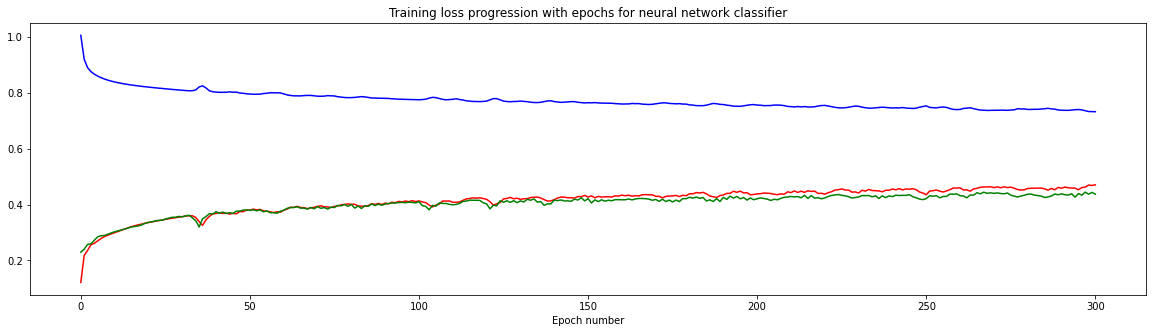

In [55]:
y_hat_test = forward_prop_2_layer_nn(100.0*x_test,weights_nn)[-1]
print("Stats for neural network classifier")
print("Learning rate:", 0.015)
print("Training set final mean loss:", nn1_loss_history[-1])
print("Test set mean loss:",mean_sum_of_squared_errors_2_layer_nn(y_test,
                                                      y_hat_test, weights_nn))
print("Test set accuracy:", get_accuracy(y_hat_test, y_test),"%\n")

plt.figure(figsize=(20,5))
plt.title("Training loss progression with epochs for neural network classifier")
plt.xlabel("Epoch number")
plt.plot(nn1_loss_history, 'b', label="Training loss")
plt.plot(np.array(nn1_train_acc_history)/100, 'r', label="Training accuracy")
if use_val: plt.plot(np.array(nn1_val_acc_history)/100, 'g',
                     label="Validation accuracy")
plt.legend()
#plt.savefig("images/linear_training_loss.png")
plt.show()

# Part 3: Stochastic gradient descent

In [8]:
no_epochs = 300
H = 200
weights_nn = initialize_2_layer_nn((x_train.shape[1],H,K))
print("Weight sizes")
for weight in weights_nn:
  print(weight.shape)
print()

nn2_loss_history = []
nn2_train_acc_history = []
nn2_val_acc_history = []
learning_rate_nn2 = 0.001
learning_rate_decay_nn2 = 0.99
regularization_nn2 = 1e-4
batch_size = 500
steps_per_epoch = int(Ntr/batch_size)

tik = time.time()

seed = 0
rng = np.random.default_rng(seed=seed)

print("Starting training of 2-layer Neural Network with sgd for", no_epochs, "epochs")
for epo in range(no_epochs+1):
  # Shuffle training data
  ind = np.arange(Ntr)
  rng.shuffle(ind)
  x_train_shuffled = x_train[ind]*100.0
  y_train_shuffled = y_train[ind]

  # Learning step down as batches
  for step in range(steps_per_epoch):
    batch = x_train_shuffled[step*batch_size: (step+1)*batch_size]
    batch_labels = y_train_shuffled[step*batch_size: (step+1)*batch_size]
    results = forward_prop_2_layer_nn(batch,weights_nn)
    y_hat = results[-1]
    loss = mean_sum_of_squared_errors_2_layer_nn(batch_labels, y_hat, weights_nn,
                                                 regularization_nn2)
    nn2_loss_history.append(loss)
    grads = back_prop_2_layer_nn(batch_labels, [batch]+results, weights_nn)
    weights = gradient_descent_2_layer_nn(grads, weights_nn, learning_rate_nn2,
                                          regularization_nn2)

  learning_rate_nn2 *= learning_rate_decay_nn2

  # Maintain history of progression
  y_hat = forward_prop_2_layer_nn(x_train_shuffled,weights_nn)[-1]
  train_acc = get_accuracy(y_hat, y_train_shuffled)
  nn2_train_acc_history.append(train_acc)
  # Validation
  y_hat_val = forward_prop_2_layer_nn(x_val*100.0, weights_nn)[-1]
  val_acc = get_accuracy(y_hat_val, y_val)
  nn2_val_acc_history.append(val_acc)

  if not(epo%20):
    print("Epoch no.", epo, "\t| Training loss:",loss, "\t| Training accuracy:",
          np.round(train_acc,2), "\t| Validation accuracy:", np.round(val_acc,2))

tok = time.time()
etime = tok-tik
print("Training complete.",int(etime//60),"minutes and", int(etime%60),
      "seconds elapsed.")

Weight sizes
(3072, 200)
(1, 200)
(200, 10)
(1, 10)

Starting training of 2-layer Neural Network with sgd for 300 epochs
Epoch no. 0 	| Training loss: 0.8583174552751928 	| Training accuracy: 27.48 	| Validation accuracy: 27.24
Epoch no. 20 	| Training loss: 0.7642487197813229 	| Training accuracy: 42.74 	| Validation accuracy: 41.82
Epoch no. 40 	| Training loss: 0.742131597153476 	| Training accuracy: 46.04 	| Validation accuracy: 43.92
Epoch no. 60 	| Training loss: 0.7290606905981691 	| Training accuracy: 48.32 	| Validation accuracy: 45.02
Epoch no. 80 	| Training loss: 0.7039387768245684 	| Training accuracy: 49.98 	| Validation accuracy: 45.88
Epoch no. 100 	| Training loss: 0.7030024520005403 	| Training accuracy: 51.58 	| Validation accuracy: 46.8
Epoch no. 120 	| Training loss: 0.7014045364371564 	| Training accuracy: 52.6 	| Validation accuracy: 47.22
Epoch no. 140 	| Training loss: 0.6566759649611985 	| Training accuracy: 53.42 	| Validation accuracy: 47.44
Epoch no. 160 	|

Stats for neural network classifier
Learning rate: 0.015
Training set final mean loss: 0.6597407218850856
Test set mean loss: 0.7221219539642334
Test set accuracy: 47.45 %



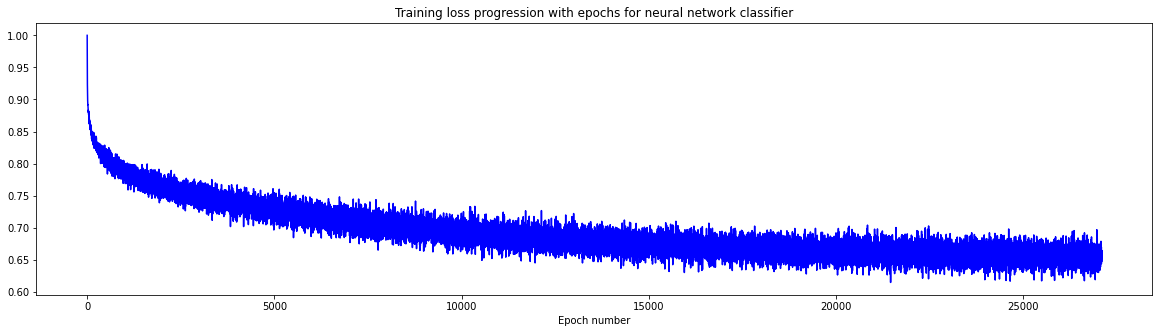

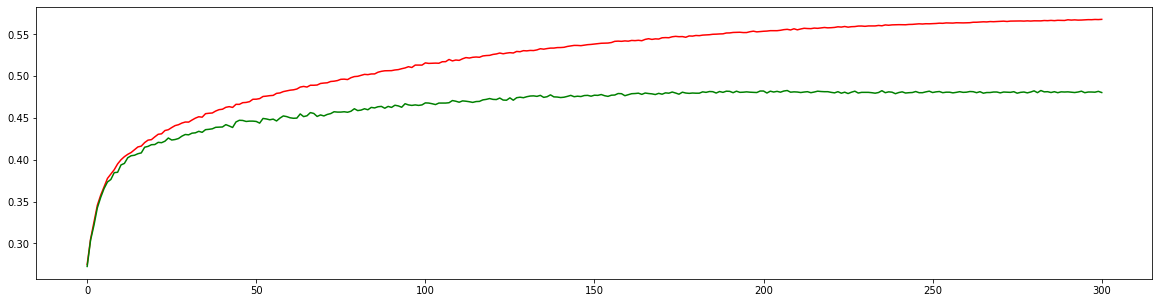

In [10]:
y_hat_test = forward_prop_2_layer_nn(100.0*x_test,weights_nn)[-1]
print("Stats for neural network classifier")
print("Learning rate:", 0.015)
print("Training set final mean loss:", nn2_loss_history[-1])
print("Test set mean loss:",mean_sum_of_squared_errors_2_layer_nn(y_test, y_hat_test, weights_nn))
print("Test set accuracy:", get_accuracy(y_hat_test, y_test),"%\n")

plt.figure(figsize=(20,5))
plt.title("Training loss progression with epochs for neural network classifier")
plt.xlabel("Epoch number")
plt.plot(nn2_loss_history, 'b', label="Training loss")
plt.figure(figsize=(20,5))
plt.plot(np.array(nn2_train_acc_history)/100, 'r', label="Training accuracy")
if use_val: plt.plot(np.array(nn2_val_acc_history)/100, 'g', label="Validation accuracy")
#plt.savefig("images/linear_training_loss.png")
plt.show()

# Part 4: CNN

In [11]:
# Download and categorize data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
K = len(np.unique(y_train))

# Compute data parameters
Ntr = x_train.shape[0]
Nte = x_test.shape[0]

# Normalize pixel values
x_train, x_test = x_train/255.0, x_test/255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert labels from integers to binary
y_train = keras.utils.to_categorical(y_train, num_classes=K)
y_test = keras.utils.to_categorical(y_test, num_classes=K)

# Generate train validation splits
train_val_split = 0.9
use_val = False if train_val_split==1.0 else True
if use_val:
  x_train, x_val = x_train[:int(Ntr*train_val_split)], x_train[int(Ntr*train_val_split):]
  y_train, y_val = y_train[:int(Ntr*train_val_split)], y_train[int(Ntr*train_val_split):]
  Ntr,Nv = x_train.shape[0],x_val.shape[0]

class_labels = ["airplane", "automobile", "bird", "cat", "deer", 
                "dog", "frog", "horse", "ship", "truck"]

print("Training data size :", x_train.shape, "\nTraining label size :",\
      y_train.shape)
if use_val: print("Validation data size:", x_val.shape,\
      "\nValidation label size:", y_val.shape)
print("Test data size :", x_test.shape, "\nTest label size :", y_test.shape)
print("No of classes :", K)

Training data size : (45000, 32, 32, 3) 
Training label size : (45000, 10)
Validation data size: (5000, 32, 32, 3) 
Validation label size: (5000, 10)
Test data size : (10000, 32, 32, 3) 
Test label size : (10000, 10)
No of classes : 10


In [13]:
model = keras.Sequential([
                          keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(32,32,3), name="C32"),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Conv2D(64, (3,3), padding='same', name="C64_1"),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Conv2D(64, (3,3), padding='same', name="C64_2"),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Flatten(),
                          keras.layers.Dense(64, activation='sigmoid'),
                          keras.layers.Dense(10, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C32 (Conv2D)                 (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
C64_1 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
C64_2 (Conv2D)               (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [23]:
learning_rate_cnn = 0.015
learning_rate_decay_cnn = 0.001
sgd = keras.optimizers.SGD(learning_rate_cnn, 0.0, decay=learning_rate_decay_cnn)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Ran the model fit in Kaggle using the GPUs: 15mins elapsed. Faster than running on Colab
history = model.fit(x_train, y_train, batch_size=50, epochs=1, validation_data=(x_val, y_val))

900/900 [==============================] - 78s 87ms/step - loss: 1.8072 - accuracy: 0.3644 - val_loss: 1.6861 - val_accuracy: 0.3992


In [25]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=10000)
print("Loss:", np.round(loss,5), "Accuracy:", np.round(100*accuracy,2),"%")

1/1 [==============================] - 4s 4s/step - loss: 1.6772 - accuracy: 0.4122
Loss: 1.67721 Accuracy: 41.22 %
